##  Environment Setup

In this step, we:
- Install required libraries
- Configure Google Generative AI using a secure API key from Colab Secrets

In [15]:
!pip install -q -U google-generativeai pandas

import google.generativeai as genai
import pandas as pd
import json
import io
from google.colab import userdata

GOOGLE_API_KEY = userdata.get("GOOGLE_API_KEY")
genai.configure(api_key=GOOGLE_API_KEY)


##  Load Document Image

Here we load the image that will be analyzed by the AI model.



Image '/content/Invoice.png' loaded successfully.


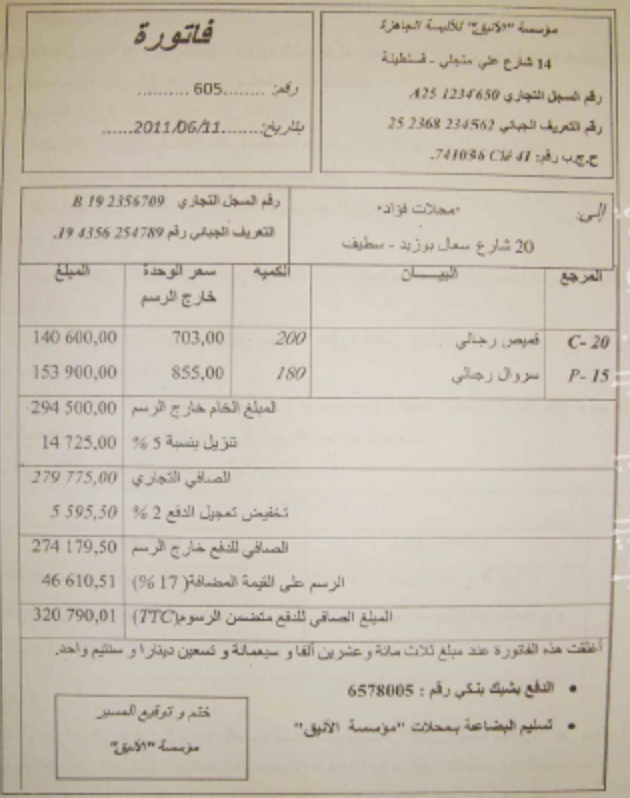

In [16]:
from google.colab import files
import PIL.Image

image_path = "/content/Invoice.png"
img = PIL.Image.open(image_path)
print(f"Image '{image_path}' loaded successfully.")
display(img)


## OCR & Data Extraction and showing raw AI Response


In this step, we use **Gemini 2.5 Flash** to:

- Extract all visible text and numbers
- Understand tables, lists, and key-value pairs
- Return a **clean structured JSON** response
- Then displaying the **raw response** returned by the AI model
before any cleaning or parsing.


In [24]:
import json
import google.generativeai as genai

model = genai.GenerativeModel('gemini-2.5-flash')

prompt = """
Act as an expert OCR and intelligent data extraction system.
Analyze the attached image and extract ALL information you can see.

YOUR TASK:
1. Identify what type of document/image this is (invoice, receipt, ID card, form, table, screenshot, etc.)
2. Extract ALL text, numbers, dates, and structured data
3. Organize the data in a logical JSON structure based on what you find
4. Preserve the original language of the text

RULES:
- If you see a table, extract it as an array of objects
- If you see key-value pairs, extract them as an object
- If you see a list, extract it as an array
- For numerical values, use numbers not strings
- For missing data, use null
- Do not add markdown formatting (no ```, no "json" prefix)
- Return ONLY valid JSON

OUTPUT FORMAT:
{
  "document_type": "type of document you identified",
  "extracted_data": {
  },
  "metadata": {
    "language": "detected language(s)",
    "confidence": "high/medium/low",
    "notes": "any important observations"
  }
}

Analyze the image intelligently and return the JSON.
"""

print(" Sending to Gemini... Please wait.")
response = model.generate_content([prompt, img])

print("\n" + "=" * 60)
print(" EXTRACTED DATA")
print("=" * 60)
print(response.text)

 Sending to Gemini... Please wait.

 EXTRACTED DATA
{
  "document_type": "Invoice",
  "extracted_data": {
    "invoice_details": {
      "invoice_number": 605,
      "invoice_date": "2011/06/11"
    },
    "supplier_information": {
      "name": "مؤسسة \"الأميج\" للألبسة الجاهزة",
      "address": "14 شارع علي منجلي - قسنطينة",
      "commercial_register_number": "A25 1234650",
      "tax_identification_number": "25 2368 234562",
      "p_o_box_number": "41 Cج 741036"
    },
    "customer_information": {
      "name": "محلات فؤاد",
      "address": "20 شارع سعال بوزيد - سطيف",
      "commercial_register_number": "B 19 2356709",
      "tax_identification_number": "19 4356 254789"
    },
    "items": [
      {
        "reference": "C-20",
        "description": "قميص رجالي",
        "quantity": 200,
        "unit_price_excl_tax": 703.00,
        "amount_excl_tax": 140600.00
      },
      {
        "reference": "P-15",
        "description": "سروال رجالي",
        "quantity": 180,
      

# Since the AI-generated output may contain OCR artifacts, mixed numerals, and formatting noise, a generic recursive normalization pipeline was applied to clean all textual fields

In [33]:
import re
ARABIC_TO_ENGLISH_NUMBERS = {
    "٠": "0", "١": "1", "٢": "2", "٣": "3", "٤": "4",
    "٥": "5", "٦": "6", "٧": "7", "٨": "8", "٩": "9"
}

def normalize_arabic_numbers(text: str) -> str:
    for ar, en in ARABIC_TO_ENGLISH_NUMBERS.items():
        text = text.replace(ar, en)
    return text

def clean_text(text: str) -> str:
    if not text:
        return text
    text = normalize_arabic_numbers(text)
    text = re.sub(r"\s+", " ", text)
    text = text.replace("،", ",")
    text = text.replace("؛", ";")
    text = re.sub(r"[^\w\s\-\/\.\,\(\)\"']", "", text)

    return text.strip()
def clean_ai_output(data):
    """
    Recursively clean AI-generated structured data
    Works for dict, list, str, numbers
    """
    if isinstance(data, dict):
        return {
            key: clean_ai_output(value)
            for key, value in data.items()
        }
    elif isinstance(data, list):
        return [clean_ai_output(item) for item in data]

    elif isinstance(data, str):
        return clean_text(data)

    else:
        return data
cleaned_data = clean_ai_output(response.text)
print("\n" + "=" * 60)
print(cleaned_data)
print("=" * 60)


"document_type" "Invoice", "extracted_data"  "invoice_details"  "invoice_number" 605, "invoice_date" "2011/06/11" , "supplier_information"  "name" "مؤسسة "الأميج" للألبسة الجاهزة", "address" "14 شارع علي منجلي - قسنطينة", "commercial_register_number" "A25 1234650", "tax_identification_number" "25 2368 234562", "p_o_box_number" "41 Cج 741036" , "customer_information"  "name" "محلات فؤاد", "address" "20 شارع سعال بوزيد - سطيف", "commercial_register_number" "B 19 2356709", "tax_identification_number" "19 4356 254789" , "items"   "reference" "C-20", "description" "قميص رجالي", "quantity" 200, "unit_price_excl_tax" 703.00, "amount_excl_tax" 140600.00 ,  "reference" "P-15", "description" "سروال رجالي", "quantity" 180, "unit_price_excl_tax" 855.00, "amount_excl_tax" 153900.00  , "summary"  "gross_amount_excl_tax" 294500.00, "discount_percentage_1" 5, "discount_amount_1" 14725.00, "commercial_net_amount" 279775.00, "early_payment_discount_percentage" 2, "early_payment_discount_amount" 5595.50

##  Clean & Parse JSON

Since AI responses may contain extra text, we:
- Remove any markdown artifacts
- Extract the valid JSON block
- Parse it safely into a Python dictionary
- Prepare clean structures for Excel export


In [34]:
import json
import pandas as pd
import google.generativeai as genai

model = genai.GenerativeModel('gemini-2.5-flash')

prompt = f"""
You are an Excel formatting expert. Organize this extracted data into clean, professional sections.

INPUT DATA:
{cleaned_data}

ORGANIZATION RULES:
1. Create DISTINCT sections - no duplication between sections
2. Header Section: Document title, numbers, dates, parties info (seller/buyer names, addresses)
3. Financial Section: All monetary totals, taxes, subtotals, discounts, payment info
4. Items/Details Section: Line items, products, services (as a table with columns)
5. Notes Section: Any additional information or remarks

OUTPUT FORMAT (return ONLY valid JSON, no markdown):
{{
  "header": {{"Field Name": "value", ...}},
  "financial": {{"Field Name": value, ...}},
  "items": {{
    "columns": ["Column1", "Column2", ...],
    "rows": [["val1", "val2", ...], ...]
  }},
  "notes": "any additional text"
}}

CRITICAL RULES:
- Each piece of data appears in ONLY ONE section
- Remove all duplicate information
- Use clear field names
- Numbers as numbers, not strings
- If a section is empty, use null
- Return ONLY the JSON object
"""

print(" Organizing data into sections...")
ai_response = model.generate_content(prompt)

clean_text = ai_response.text.replace('```json', '').replace('```', '').strip()
organized = json.loads(clean_text)

dfs = {}

if organized.get('header'):
    dfs['Header'] = pd.DataFrame([organized['header']]).T.reset_index()
    dfs['Header'].columns = ['Field', 'Value']

if organized.get('financial'):
    dfs['Financial'] = pd.DataFrame([organized['financial']]).T.reset_index()
    dfs['Financial'].columns = ['Field', 'Value']

if organized.get('items') and organized['items']:
    dfs['Items'] = pd.DataFrame(organized['items']['rows'], columns=organized['items']['columns'])

if organized.get('notes'):
    dfs['Notes'] = pd.DataFrame([['Notes', organized['notes']]], columns=['Field', 'Value'])

print("\n Data organized into sections:")
for name, df in dfs.items():
    print(f"\n {name}:")
    print(df.to_string(index=False))


 Organizing data into sections...

 Data organized into sections:

 Header:
                              Field                          Value
                      document_type                        Invoice
                     invoice_number                            605
                       invoice_date                     2011/06/11
                      supplier_name مؤسسة "الأميج" للألبسة الجاهزة
                   supplier_address    14 شارع علي منجلي - قسنطينة
supplier_commercial_register_number                    A25 1234650
 supplier_tax_identification_number                 25 2368 234562
             supplier_po_box_number                   41 Cج 741036
                      customer_name                     محلات فؤاد
                   customer_address      20 شارع سعال بوزيد - سطيف
customer_commercial_register_number                   B 19 2356709
 customer_tax_identification_number                 19 4356 254789

 Financial:
                            Field      V

# export the data into excel file

In [27]:
filename = "extracted_data.xlsx"

with pd.ExcelWriter(filename, engine='openpyxl') as writer:
    for sheet_name, df in dfs.items():
        df.to_excel(writer, sheet_name=sheet_name, index=False)

print(f"\n Saved to: {filename}")
print(f" Created {len(dfs)} sheets: {', '.join(dfs.keys())}")


 Saved to: extracted_data.xlsx
 Created 4 sheets: Header, Financial, Items, Notes


# exporting the data in a single CSV file.


In [35]:
import pandas as pd

combined_rows = []

for table_name, df in dfs.items():
    temp_df = df.copy()
    temp_df["table_name"] = table_name
    combined_rows.append(temp_df)

final_df = pd.concat(combined_rows, ignore_index=True)

filename = "extracted_data.csv"
final_df.to_csv(filename, index=False, encoding="utf-8-sig")

print(f"\nSaved all tables into single CSV file: {filename}")
print(f"Included tables: {', '.join(dfs.keys())}")



Saved all tables into single CSV file: extracted_data.csv
Included tables: Header, Financial, Items, Notes
